# Solving a different problem

With precious little time left to complete the work and PowerTech paper, I've decided it would be good to have a backup.

## Temperature as the objective

It would be nice to avoid solving a nonconvex QCQP with a shell constraint. What if, instead of minimizing wind deviations, we fixed a wind forecast inaccuracy limit (placing bounds on deviation variables) and maximized heat input to each line? This would give us a set of wind patterns, each one based on $x\%$ maximum forecast inaccuracy, that would maximally heat one line in the network. We could then filter that list based on which line temperatures are greatest, and sort remaining patterns according to distance from the forecast. In the end, we would have the most likely wind pattern (assuming inaccuracy of $x\%$) guaranteed to saturate a line.

We get a quadratic program like this:

\begin{align}
&& z_{ik}^* = \max~ & z^\top Q_{\theta} z \\
s.t. && Az &= b \\
&& x &\leq c\cdot P0  \\
&& x &\geq -c\cdot P0
\end{align}

where $z$ is the vector of all variables, $x$ contains only wind deviation variables, and $P0$ is the vector of wind forecast values. We define $A$ to ensure the right line $(i,k)$ is chosen, and we repeat the optimization to find $z_{ik}^*$ for every line in the network. This gives us a set of system states (including wind deviations), each of which reflects maximal heating of one line in the network subject to the given forecast inaccuracy.

One nice side-effect of this formulation is that we don't have to worry about wind farm output going negative. Deviations are bounded, so they cannot exceed forecast values as long as $c\leq 1$.

## Understanding the output

Now suppose $z_{ik}^*$ results in a temperature of $T_{ik}^*$ for line $(i,k)$, and the line's maximum allowable temperature is $T_{ik}^{max}$. If $T_{ik}^* \geq T_{ik}^{max}$, we have a problem. Otherwise, there is no wind pattern within the forecast inaccuracy limits that will excessively heat line $(i,k)$. We remove $z_{ik}^*$ from our list and move on.

In the end we have a set of problematic system states. If this set is empty, we need to increase the inaccuracy limit and re-do the optimization. Otherwise, we rank members of the set according to $\lVert x_{ik}^*\rVert$, the normed distance between the forecast and the actual wind pattern. This gives us a set of "extreme events" sorted roughly by likelihood (since patterns closer to the forecast are more likely to occur).

## Reusing existing code

There isn't time to solve this new problem from scratch, but I can reuse many elements of code I have already written.

* $Q_\theta$ selects only the $\hat{\theta}_{ik}$ variables from $z$. This is the same function it has in the original problem, so the code doesn't need alteration.

* $Ax=b$ ensures power balance and implements distributed slack. It also defines $\hat{\theta}_{ik}$ appropriately. I do not need to change this at all.

* All I need to do is add constraints to limit wind deviations (otherwise, the objective could increase without bound).

## Building and solving a model

In [1]:
####### IMPORTS: JULIA PACKAGES ########
using JuMP
using Mosek
using Ipopt

####### IMPORTS: INSTANTON CODE ########
# Get instanton code into workspace:
include("../src/TemporalInstanton.jl")
include("../src/TrustRegionSubproblem.jl")
using TemporalInstanton, TrustRegionSubproblem

In [2]:
function maxTempModel(Qobj,A,b,Qtheta,P0)
    # Build a model:
    m = Model(solver = IpoptSolver()) # Use MOSEK to solve model
    numRows,numVars = size(A)
    Nr = length(find(P0))
    @defVar(m,z[1:numVars])
    setObjective(m,:Max,sum([(Qtheta[i,i]*z[i]^2) for i in 1:size(Qtheta,1)]))

    @defConstrRef LinearConstrs[1:numRows]
    for i in 1:numRows
        LinearConstrs[i] = @addConstraint(m, sum([A[i,k]*z[k] for k in 1:numVars]) == b[i])
    end

    windPos = find(diag(Qobj))
    windVal = P0[find(P0)]
    @defConstrRef windLims[1:length(windPos)]
    for i = 1:length(windPos)
        windLims[i] = @addConstraint(m, -c*windVal[i] <= z[windPos[i]] <= c*windVal[i])
    end
    return m,z,LinearConstrs
end

maxTempModel (generic function with 1 method)

In [3]:
####### IMPORTS: DATA ACQUISITION ########
include("../src/tmp_inst_rts96.jl")

psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

####### DATA LINKING ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 1. # Heating constant
G0 = [Gp,Gp.*0.95,Gp.*0.9]
D0 = [Dp,Dp.*0.95,Dp.*0.9]
P0 = [Rp,Rp,Rp]
kQobj = 0 # Should always be zero; objective has no constant term
c = 0.2 # Forecast inaccuracy limit

n = size(Y,1)
T = int(length(G0)/n) # infer number of time steps
nr = length(Ridx)

Qobj = tmp_inst_Qobj(n,nr,T)
# Augment Qobj with additional rows and columns of zeros:
Qobj = tmp_inst_pad_Q(full(Qobj),T)
A1 = full(tmp_inst_A(Ridx,T,Y,ref,k))
A1 = [A1 zeros((n+1)*T,T)]
b = tmp_inst_b(n,T,G0,P0,D0)
# Augment b with new elements:
tmp_inst_pad_b(b,T)
Qtheta = tmp_inst_Qtheta(n,nr,T)#,tau)
# Qtheta does not need to be augmented.

# Changing:
lines = [(f[i],t[i]) for i in 1:length(f)];

In [4]:
score = Float64[]
result = Symbol[]
α = Array(Vector{Float64},0)

θ = Array(Array,0)
x = Array(Array,0)
diffs = Array(Array,0)

# Loop through all lines:
for line in lines
    deviations = Array(Vector{Float64},0) # array of vectors with Float64 values
    angles = Array(Vector{Float64},0) # array of vectors with Float64 values
    alpha = Float64[]

    # Create instance of instanton problem
    A2 = tmp_inst_A_scale(n,Ridx,T,tau,ref,line)
    # Augment A with new rows:
    A = [A1; A2]

    # Create solver model
    m,z,LinearConstrs = maxTempModel(Qobj,A,b,Qtheta,P0)
    
    # Solve
    status = solve(m)
    
    # Store results
    xvec = getValue(z)[:]
    push!(score, getObjectiveValue(m))
    push!(result,status)

    # Variable breakdown:
    # (nr+n+1) per time step
    #   First nr are deviations
    #   Next n are angles
    #   Last is mismatch
    # T variables at the end: anglediffs
    for t = 1:T
        push!(deviations,xvec[(nr+n+1)*(t-1)+1:(nr+n+1)*(t-1)+nr])
        push!(angles,xvec[(nr+n+1)*(t-1)+nr+1:(nr+n+1)*(t-1)+nr+n])
        push!(alpha,xvec[(nr+n+1)*(t)])
    end
    push!(θ,angles)
    push!(x,deviations)
    push!(diffs,xvec[end-T+1:end])
    push!(α,alpha)
    
    println(length(result))
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.11.7, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1032
Number of nonzeros in inequality constraint Jacobian.:       54
Number of nonzeros in Lagrangian Hessian.............:      279

Total number of variables............................:      279
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

In [8]:
using PyPlot

INFO: Loading help data...


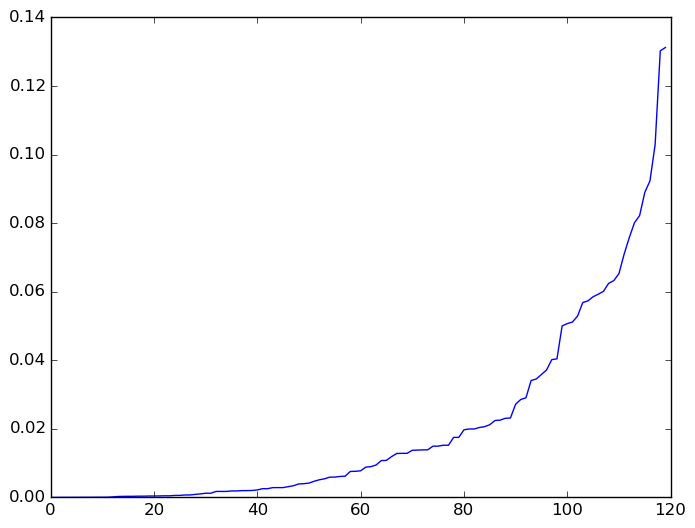

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f49a76d2d90>

In [9]:
plot(sort(score))